En ting å legge merke til når notatboken kjøres er at det må kjøres fra topp til bunn, pga tror det er litt hopping frem og tilbake. Så for å passe på at variabelverdier ikke overskiver hverandre osv så kjør fra topp til bunn.

Først starter vi med å implementere alle bibliotekene vi trenger først slik at de alle er samlet et sted for ryddigheten sin skyld da flere bilbioteker brukes i ulike kode blokker.

In [42]:
from google.colab import files
import io, pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import gradio as gr
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

Under så brukte vi ChatGPT for å hjelpe implementering av datasettet våres. Vi fant ut at det var lettest å bare laste opp datasettet manuelt slik at vi alle kunne lett ha tilgang på koden sammtidig uten å måtte tenke på at Path-en ikke funket osv.

In [43]:
uploaded = files.upload()

fname = next(iter(uploaded))
dataset = pd.read_csv(io.BytesIO(uploaded[fname]))


Saving housing.csv to housing (2).csv


Etter vi har lastet ned datasettet våres, så ser vi på informasjonen som blir representert i datasettet:

In [80]:
dataset = pd.read_csv("housing.csv")
print(f'Vi ser her lengden på datasettet er: {len(dataset)}')
print('\n')
dataset.info()

Vi ser her lengden på datasettet er: 20640


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Vi ser og at det er en ikke numerisk verdi i "ocean_proximity" kolonnen så vi sjekker ut hvilke verdier som blir representert i denne kolonnen.

In [81]:
print(sorted(dataset["ocean_proximity"].dropna().unique().tolist()))

['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


Når vi ser på informasjonen av datasettet våres, og verdiene som er i kolonnen så kan vi konkludere at det er 2 problemer vi må fikse før vi begynner å putte datasettet våres inn i en ML-modell:

1. ocean_proximity er en kategorisk tekstvariabel.
2. det er null-verdier i "total_bedrooms"

Vi ønsker å løse begge problemene, men starter med problem 1. Vi ønsker å representere verdiene på en annen måte som er tolkbar for ML-modellen, dette gjør vi med å kode kolonnen om til one-hot-koding.

Så påfører vi one-hot-kodingen, dette er for at modellen skal kunne bruke verdiene i kolonnen uten å tolke en falsk rekkefølge. Dette lager én binær kolonne per kategori og vi fjerner den orginale tekstkolonnen. Siden vi bruker en tre-basert modell, beholder vi alle dummykolonnene. Vi beholder disse kolonnene da det gjør det enklere for treet å lage rene splitt per kategori.

In [82]:
dummies = pd.get_dummies(dataset["ocean_proximity"], prefix="ocean", dtype=int)
dataset = pd.concat([dataset.drop(columns=["ocean_proximity"]), dummies], axis=1)

X = dataset.drop(columns=["median_house_value"]).copy()
y = dataset["median_house_value"].copy()

dataset.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_<1H OCEAN,ocean_INLAND,ocean_ISLAND,ocean_NEAR BAY,ocean_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


Før vi ser videre på problem 2 så skal vi se på et heatmap av datasette våres som viser korrelasjon mellom numeriske variabler.

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

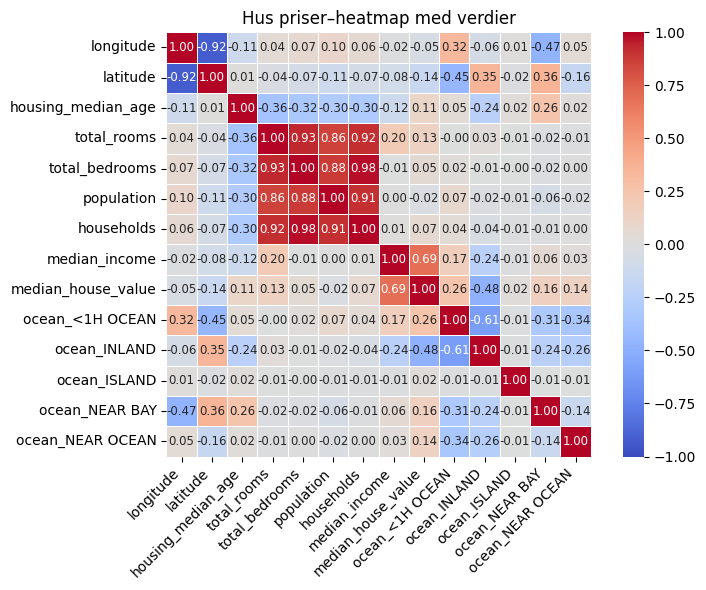

In [84]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap="coolwarm", vmin=-1, vmax=1,
    square=True, linewidths=.5,
    annot_kws={"size":8.5}
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Hus priser–heatmap med verdier")
plt.tight_layout()
plt.show()

På grunn av høy korrelasjon mellom totalsummener i variablene total_rooms, total_bedrooms, population og households. For å redusere redundans og fange mer meningsfulle signaler for pris, transformerer vi dem til forholds-/tetthetsvariabler og fjerner de opprinnelige totalsummene:

*   rooms_per_household = total_rooms / households
*   bedrooms_per_room = total_bedrooms / total_rooms
*   population_per_household = population / households

Vi evaluerer effekten ved å trene samme modell før og etter transformasjonen, og beholder varianten som gir lavest RMSE/MAE og høyest R². Før vi evaluerer effekten av å trene modellen med ulike variabler så må først finne ut svaret på problem 2 der vi har manglende verdier i "total_bedrooms". Vi finner ut hvor mye prosentandel av dataen som mangler for å kunne bestemme hvordan vi skal håndtere de manglende verdiene.

In [85]:
missing_cnt = dataset.isna().sum().sort_values(ascending=False)
missing_pct = (dataset.isna().mean()*100).round(2)
report = pd.DataFrame({"missing": missing_cnt, "percent": missing_pct})
print(report[report["missing"] > 0])


                missing  percent
total_bedrooms      207      1.0


Vi har ulike måter for å For å finne ut om vi ønsker å droppe radene, eller å imputere median, så sammenligner vi modellens ytelse på både dataset med og uten imputering, også velger vi varianten som gir lavest MAE/RMSE og høyest R².

Ytelse av datasett med imputering av median:

In [86]:
dataset_med_fyll = dataset.copy()

X_med_fyll = dataset.drop(columns="median_house_value")
y_med_fyll = dataset['median_house_value']

X_trainF, X_testF, y_trainF, y_testF = train_test_split(X_med_fyll, y_med_fyll, random_state=42)

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

preprocess = ColumnTransformer(
    [("num", SimpleImputer(strategy="median"), num_cols),
     ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)]
)

pipe = Pipeline([("prep", preprocess),
                 ("model", RandomForestRegressor(random_state=42, n_estimators=300, n_jobs=-1))])

pipe.fit(X_trainF, y_trainF)

y_predF = pipe.predict(X_testF)

mae = mean_absolute_error(y_testF, y_predF)
mse = mean_squared_error(y_testF, y_predF)
rmse = np.sqrt(mse)
r2 = r2_score(y_testF, y_predF)

print(f"Antall rader: {len(dataset_med_fyll)}")
print(f"MAE med fyll: {mae:,.0f} | RMSE med fyll: {rmse:,.0f} | R²: {r2:.3f}")


Antall rader: 20640
MAE med fyll: 31,462 | RMSE med fyll: 48,657 | R²: 0.821


Så fjerner vi alle radene der totalt antall soverom mangler også regner vi ut MAE/RMSE og R²:

In [87]:
print(f"Lengden før radene med NaN fra total_bedrooms fjernet: {len(dataset)} \n")
dataset = dataset.dropna(subset=["total_bedrooms"]).reset_index(drop=True)
print(f"Lengden ETTER radene med NaN fra total_bedrooms fjernet: {len(dataset)} \n")
dataset.info()

Lengden før radene med NaN fra total_bedrooms fjernet: 20640 

Lengden ETTER radene med NaN fra total_bedrooms fjernet: 20433 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20433 entries, 0 to 20432
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_<1H OCEAN     20433 non-null  int64  
 10  ocean_INLAND        20433 non-null  int64  
 11  ocean_ISLAND        20433 non-null  int64  
 12  ocean_NEAR BAY      20433 non-null  int64  
 13  ocean_NEAR OCEAN    204

In [88]:
X = dataset.drop(columns="median_house_value")
y = dataset['median_house_value']

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

preprocess = ColumnTransformer(
    [("num", SimpleImputer(strategy="median"), num_cols),
     ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)]
)

pipe = Pipeline([("prep", preprocess),
                 ("model", RandomForestRegressor(random_state=42, n_estimators=300, n_jobs=-1))])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Antall rader: {len(dataset)}")
print(f"MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.3f}")



Antall rader: 20433
MAE: 31,568 | RMSE: 48,621 | R²: 0.827


Nå når vi har regnet MAE/RMSE og R² for både imputering av median for de manglende verdiene, og når vi dropper radene der de manglende verdiene er, og resultatetene var:

MAE med fyll:  | RMSE med fyll:  | R²:

```
Med imputering:
MAE  = 31,436
RMSE = 48,459
R²   = 0.826

Dropping av rader:
MAE  = 31,568
RMSE = 48,621
R²   = 0,827
```

Vi ser her at utregningen gir oss nesten like verdier, men det er med imputering som gir lavest MAE/RMSE, ikke høyest R², men forholdet mellom MAE/RMSE og R² er bedre med imputering enn uten. Så da velger vi med imputering. I svaret så ser vi her at pga RMSE er en del høyere enn MAE forteller oss at vi har noen større avvik i datasettet.

In [89]:
dataset = dataset_med_fyll.copy()
len(dataset)

20640

Nå når vi har fikset de 2 probleme våres så nå skal vi se på modellen før og etter transformering om det gir oss mest nøyaktighet.

In [90]:
dt = dataset.copy()

dt["rooms_per_household"]      = dt["total_rooms"]    / dt["households"]
dt["bedrooms_per_room"]        = dt["total_bedrooms"] / dt["total_rooms"]
dt["population_per_household"] = dt["population"]     / dt["households"]

import numpy as np
for c_dt in ["rooms_per_household", "bedrooms_per_room", "population_per_household"]:
    dt[c_dt] = dt[c_dt].replace([np.inf, -np.inf], np.nan)

dt.drop(columns=["total_rooms", "total_bedrooms", "households", "population", "ocean_proximity_num"],
        inplace=True, errors="ignore")

y_dt = dt["median_house_value"].copy()
X_dt = dt.drop(columns=["median_house_value"], errors="ignore").copy()

num_cols_dt = X_dt.select_dtypes(include=np.number).columns
cat_cols_dt = X_dt.select_dtypes(exclude=np.number).columns

preprocess_dt = ColumnTransformer(
    [
        ("num", SimpleImputer(strategy="median"), num_cols_dt),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_dt),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

rf_dt = RandomForestRegressor(random_state=42, n_estimators=300, n_jobs=-1)

pipe_dt = Pipeline([
    ("prep", preprocess_dt),
    ("model", rf_dt),
])

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(
    X_dt, y_dt, test_size=0.2, random_state=42)

pipe_dt.fit(X_train_dt, y_train_dt)
y_pred_dt = pipe_dt.predict(X_test_dt)

mae_dt  = mean_absolute_error(y_test_dt, y_pred_dt)
rmse_dt = float(np.sqrt(mean_squared_error(y_test_dt, y_pred_dt)))
r2_dt   = r2_score(y_test_dt, y_pred_dt)

print(f"Antall rader (dt): {len(dt)}")
print(f"MAE: {mae_dt:,.0f} | RMSE: {rmse_dt:,.0f} | R²: {r2_dt:.3f}")


Antall rader (dt): 20640
MAE: 31,256 | RMSE: 48,911 | R²: 0.817


Nå når vi har regnet ut nøyaktigheten for ML-modellen for tranformerte verdier, og vi regnet ut nøyaktigheten uten nye verdier tidligere så kan vi se på resultatet:

```
Uten tranformering:
MAE  = 31,436
RMSE = 48,459
R²   = 0.826

Med transformering:
MAE  = 31,256
RMSE = 48,911
R²   = 0.817

```

Vi kan konkludere med at det er ganske likt om vi transformerer dataen eller ikke, men vi ser at det er litt bedre å ikke gjøre det. Så da beholder vi bare orginalkolonnene før omgjøringen.

In [91]:
dataset = dataset_med_fyll.copy()

Nå når vi har funnet ut og omgjort datasettet til det beste vi kan, så kan vi se litt på nøyaktigheten til modellen. Så for å vurdere om modellen overfitter så må vi se på MAE/RMSE og R^2 veriden til test og train settet.

In [92]:
y_pred_tr = pipe.predict(X_train)
y_pred_te = pipe.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_tr))
rmse_te = np.sqrt(mean_squared_error(y_test,  y_pred_te))
r2_tr   = r2_score(y_train, y_pred_tr)
r2_te   = r2_score(y_test,  y_pred_te)

print(f"TRAIN → RMSE: {rmse_tr:,.0f} | R²: {r2_tr:.3f}")
print(f"TEST  → RMSE: {rmse_te:,.0f} | R²: {r2_te:.3f}")
print(f"Gap R²: {r2_tr - r2_te:.3f} | RMSE-ratio (test/train): {rmse_te/rmse_tr:.2f}")


TRAIN → RMSE: 17,875 | R²: 0.976
TEST  → RMSE: 48,621 | R²: 0.827
Gap R²: 0.149 | RMSE-ratio (test/train): 2.72


Som vi ser på resultatene over så er treningsettet nesten helt uten feil, og test settet er mye dårligere resultat på. Dette kan representere overfitting da våres Random Forest får vokst for dypt slik at den kan "huske" treningspunktene våres. Vi best at det skjer overfitting ved at forskjellen mellom testdata og treningsdata er så stor forskjell på da det har skjedd en generaliseringsfeil. Ved at treet er for dypt så blir små detaljer fra treningsettet tatt med som ikke gjentas i test som oftest.



---



Ved å fikse denne overfittingen så må vi begrense trekompleksiteten til modellen slik at den generaliserer bedre. Dette gjør vi i koden udner ved å sette grenser på hvor "stort" treet kan "vokse".

In [102]:
pipe.set_params(
    model__n_estimators=700,
    model__max_depth=14,
    model__min_samples_leaf=4,
    model__min_samples_split=12,
    model__max_features="sqrt",

    model__bootstrap=True,
    model__oob_score=True,
)

pipe.fit(X_train, y_train)
print("OOB R²:", pipe.named_steps["model"].oob_score_)


OOB R²: 0.7982218620544547


Så under tester vi treet for overfitting igjen:

In [103]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# anta at du har: pipe, X_train, X_test, y_train, y_test
y_pred_tr = pipe.predict(X_train)
y_pred_te = pipe.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_tr))
rmse_te = np.sqrt(mean_squared_error(y_test,  y_pred_te))
r2_tr   = r2_score(y_train, y_pred_tr)
r2_te   = r2_score(y_test,  y_pred_te)

print(f"TRAIN  → RMSE: {rmse_tr:,.0f} | R²: {r2_tr:.3f}")
print(f"TEST   → RMSE: {rmse_te:,.0f} | R²: {r2_te:.3f}")

gap_r2   = r2_tr - r2_te
ratio_rm = rmse_te / rmse_tr
print(f"Gap R²: {gap_r2:.3f} | RMSE ratio (test/train): {ratio_rm:.2f}")


TRAIN  → RMSE: 40,915 | R²: 0.874
TEST   → RMSE: 52,766 | R²: 0.796
Gap R²: 0.077 | RMSE ratio (test/train): 1.29


Vi ser her nå at modellen ikke overfitter i nærheten av like mye som før. Det at Gap i R² er mindre enn 0,1 er ok, men ikke dårlig. Så fremmgang, men ikke tunet det perfekt.




Under her bruker vi delvis bruk av KI for å hjelpe å integrere ML-modellen våres i en nettside slik at man kan teste modellen på ulike input verdier. Fant ut at ocean_proximity ikke påvirker resultatet, dette er feil, men vi fikk det ikke til å funke ved hjelp verken med eller uten bruk av KI.

In [137]:
!pip -q install gradio pandas numpy scikit-learn

MAPPING = {
    "<1H OCEAN": 1,
    "INLAND": 2,
    "ISLAND": 3,
    "NEAR BAY": 4,
    "NEAR OCEAN": 5,
}

ocean_cat = ["<1H OCEAN", "INLAND", "ISLAND", "NEAR BAY", "NEAR OCEAN"]

X = dataset.drop(columns="median_house_value")
y = dataset['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

preprocess = ColumnTransformer(
    [("num", SimpleImputer(strategy="median"), num_cols),
     ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)]
)

pipe = Pipeline([("prep", preprocess),
                 ("model", RandomForestRegressor(random_state=42, n_estimators=300, n_jobs=-1))])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

METRICS_MD = (
    f"**Modellkvalitet (testsett)**\n\n"
    f"- MAE (gj.sn. feil): {mae:,.0f}\n"
    f"- RMSE (store feil straffes): {rmse:,.0f}\n"
    f"- R² (forklart varians): {r2:.3f}\n"
)

num_defaults = X.drop(columns=["ocean_proximity_num"], errors="ignore") \
                    .mean(numeric_only=True)

def default_val(name: str, fallback: float = 0.0) -> float:
    v = num_defaults.get(name, None)
    return float(v) if (v is not None and pd.notna(v)) else float(fallback)

def default_info(name: str, fmt: str = ".2f") -> str:
    v = num_defaults.get(name, None)
    if v is None or pd.isna(v):
        return ""
    return f"Gjennomsnitt: {format(float(v), fmt)}"

def predict_ui(longitude, latitude, housing_median_age, total_rooms,
               total_bedrooms, population, households, median_income,
               ocean_cat):
    # map kategorien til samme tall som i treningen
    ocean_num = MAPPING[ocean_cat]

    # bygg inn-rad; konverter tomme felt (None) til NaN så imputer tar dem
    row = {
        "longitude": longitude,
        "latitude": latitude,
        "housing_median_age": housing_median_age,
        "total_rooms": total_rooms,
        "total_bedrooms": total_bedrooms,
        "population": population,
        "households": households,
        "median_income": median_income,
        "ocean_proximity": ocean_num,
    }
    row = {k: (np.nan if v is None else v) for k, v in row.items()}

    Xo = pd.DataFrame([row])

    if hasattr(pipe, "feature_names_in_"):
        Xo = Xo.reindex(columns=pipe.feature_names_in_, fill_value=0)

    pred = float(pipe.predict(Xo)[0])
    return pred, METRICS_MD

inputs = [
    gr.Number(label="longitude",          value=None, info=default_info("longitude")),
    gr.Number(label="latitude",           value=None, info=default_info("latitude")),
    gr.Number(label="housing_median_age", value=None, info=default_info("housing_median_age")),
    gr.Number(label="total_rooms",        value=None, info=default_info("total_rooms", fmt=".0f")),
    gr.Number(label="total_bedrooms",     value=None, info=default_info("total_bedrooms", fmt=".0f")),
    gr.Number(label="population",         value=None, info=default_info("population", fmt=".0f")),
    gr.Number(label="households",         value=None, info=default_info("households", fmt=".0f")),
    gr.Number(label="median_income",      value=None, info=default_info("median_income")),
    gr.Dropdown(label="ocean_proximity", choices=list(MAPPING.keys()), value=None),
]


outputs = [
    gr.Number(label="Predicted price"),
    gr.Markdown(label="Modellkvalitet"),
]

demo = gr.Interface(
    fn=predict_ui,
    inputs=inputs,
    outputs=outputs,
    title="California Housing – demo",
    description="Gjør en pris-prediksjon av median verdien på hus i et område",
    flagging_mode="never"
)

demo.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://592ef696afeba74945.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://592ef696afeba74945.gradio.live
